#### Imports

In [18]:
import IPython.display as ipd
# % pylab inline
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from keras.callbacks import EarlyStopping

from keras import regularizers

from sklearn.preprocessing import LabelEncoder

from datetime import datetime

import os

In [4]:
# pip install librosa

#### Reading the files from our folder and creating a dataframe from it

In [5]:
#list the files
filelist = os.listdir('male') 
#read them into pandas
df_male = pd.DataFrame(filelist)

In [6]:
# Adding the 1 label to the dataframe representing male
df_male['label']='1'

In [7]:
# Renaming the column name to file
df_male = df_male.rename(columns={0:'file'})

In [50]:
df_male.head()

,file,label
0,2893-139322-0000.flac,1
1,1034-121119-0071.flac,1
2,78-369-0018.flac,1
3,322-124147-0038.flac,1
4,831-130739-0049.flac,1


In [10]:
# Checking for a file that gets automatically generated and we need to drop 
df_male[df_male['file']=='.DS_Store']

,file,label


Doing the same for the female folder

In [35]:
filelist = os.listdir('female') 
#read them into pandas
df_female = pd.DataFrame(filelist)

In [36]:
df_female['label']='0'

In [37]:
df_female = df_female.rename(columns={0:'file'})

In [49]:
df_female.head()

,file,label
0,441-128982-0010.flac,0
1,1502-122619-0039.flac,0
2,302-123504-0010.flac,0
3,1553-140048-0029.flac,0
4,32-21625-0013.flac,0


In [39]:
# Checking for a file that gets automatically generated and we need to drop 
df_female[df_female['file']=='.DS_Store']

,file,label
981,.DS_Store,0


In [40]:
# Dropping the system file
df_female.drop(981, inplace=True)

In [41]:
# Resetting the index since we dropped a row
df_female = df_female.reset_index(drop=True)

Joining both dataframes together 

In [43]:
df = pd.concat([df_female, df_male], ignore_index=True)

In [47]:
df.head()

,file,label
0,3242-67153-0018.flac,1
1,26-495-0017.flac,1
2,2817-142371-0074.flac,0
3,89-219-0006.flac,0
4,1970-28415-0024.flac,0


In [120]:
df = df.sample(frac=1).reset_index(drop=True)

We are going to do an split of train, validation and test with 70% train, 20% validation and 10% for test. We check that the randomized splits have balanced classes

In [121]:
df_train = df[:9188]

In [122]:
df_train['label'].value_counts(normalize=True)

0    0.501633
1    0.498367
Name: label, dtype: float64

In [123]:
df_validation = df[9188:11813]

In [124]:
df_validation['label'].value_counts(normalize=True)

1    0.502476
0    0.497524
Name: label, dtype: float64

In [125]:
df_test = df[11813:13125]

In [126]:
df_test['label'].value_counts(normalize=True)

1    0.500762
0    0.499238
Name: label, dtype: float64

#### Function to extract the features and label for each sound file by iterating through every row of the dataframe

In [127]:
# Although this function was modified and many parameteres were explored with, most of it
# came from Source 8 (sources in the READ.ME)

def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('voice')+'/'+str(files.file))

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    label = files.label

    return mfccs, chroma, mel, contrast, tonnetz, label

In [128]:
# Code to start the timer to see how long it takes to extract the features
startTime = datetime.now()

In [129]:
# Applying the function to the train data by accessing each row of the dataframe
features_label = df.apply(extract_features, axis=1)

/Users/jurgenarias/anaconda3/envs/dsi/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [130]:
# Code to see how long it took
print(datetime.now() - startTime)

2:53:17.949280


In [131]:
# Checking how the output looks
features_label

0        ([-366.63562, 96.04874, -69.84662, 76.36943, -...
1        ([-355.8541, 129.1912, -4.7562523, 35.801697, ...
2        ([-319.53256, 103.086426, -25.932623, 36.51116...
3        ([-362.99786, 147.51451, -17.131031, 53.30303,...
4        ([-321.77286, 99.46373, -42.24004, 57.643738, ...
                               ...                        
13120    ([-326.3073, 99.980125, -57.006733, 46.3745, -...
13121    ([-341.955, 120.1708, -42.99838, 64.313225, -2...
13122    ([-337.32944, 89.35785, -45.532562, 64.81992, ...
13123    ([-380.5992, 108.11871, -26.819942, 27.901894,...
13124    ([-295.24078, 112.396, -58.156876, 69.69957, -...
Length: 13125, dtype: object

In [ ]:
# The next code in markdown saves the numpy array (in case our kernel restarts or 
# anything happens, because it takes long to extract the features)

# np.save('features_label', features_label)

In [ ]:
# The next code loads the saved numpy array of our extracted features
# features_label = np.load('features_label.npy', allow_pickle=True)

In [154]:
# We create an empty list where we will concatenate all the features into one long feature
# for each file to feed into our neural network 

features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],
                features_label[i][4]), axis=0))

In [155]:
len(features)

13125

#### We will add the speaker id to our dataframe to have that as the label for our model and predict speakers from their voice

In [534]:
# We create an empty list where we will append all the speakers ids for each row of our
# dataframe by slicing the file name since we know the id is the first numbers before the hash
speaker = []
for i in range(0, len(df)):
    speaker.append(df['file'][i].split('-')[0])

In [538]:
# Now we create the speaker column in our dataframe and set it equal to our speaker list
df['speaker'] = speaker

In [540]:
# Checking that it worked as expected
df.head()

,file,label,speaker
0,289-121652-0001.flac,0,289
1,1363-135842-0026.flac,0,1363
2,302-123516-0003.flac,0,302
3,233-134440-0044.flac,1,233
4,322-124146-0001.flac,1,322


In [554]:
# Checking the number of speakers or the number of different people in our voice data
df['speaker'].nunique()

115

In [545]:
# Setting our labels to be equal to our speaker list
labels = speaker

In [549]:
# Checking the size of labels and making sure it matches the size of features
len(labels)

13125

#### Checking if we have balanced classes for the whole data

In [550]:
# They look somewhat balanced with a min of 56 and a max of 166, mean of 114 
# with standard deviation of 15.89 (calculated from scipy)
np.unique(labels, return_counts=True)

(array(['103', '1034', '1040', '1069', '1081', '1088', '1098', '1116',
        '118', '1183', '1235', '1246', '125', '1263', '1334', '1355',
        '1363', '1447', '150', '1502', '1553', '1578', '1594', '1624',
        '163', '1723', '1737', '1743', '1841', '1867', '1898', '19',
        '1926', '196', '1963', '1970', '198', '1992', '200', '2002',
        '2007', '201', '2092', '211', '2136', '2159', '2182', '2196',
        '226', '2289', '229', '233', '2384', '2391', '2416', '2436', '248',
        '250', '2514', '2518', '254', '26', '2691', '27', '2764', '2817',
        '2836', '2843', '289', '2893', '2911', '2952', '298', '302', '307',
        '311', '3168', '32', '3214', '322', '3240', '3242', '328', '332',
        '3374', '3436', '3486', '374', '39', '40', '403', '405', '412',
        '426', '441', '445', '446', '458', '460', '481', '587', '60',
        '625', '669', '696', '730', '78', '83', '831', '839', '87', '887',
        '89', '909', '911'], dtype='<U4'),
 array([102,  96,  8

#### Hot encoding y and pre processing X and y

In [555]:
X = np.array(features)

In [556]:
y = np.array(labels)

In [557]:
# Hot encoding y
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y))

In [563]:
X.shape

(13125, 193)

In [564]:
y.shape

(13125, 115)

In [565]:
# Choosing the first 9188 (70%) files to be our train data
# Choosing the next  2625 (20%) files to be our validation data
# Choosing the next  1312 (10%) files to be our test never before seen data
# This is analogous to a train test split but we add a validation split and we are making
# we do not shuffle anything since we are dealing with several time series, we already 
# checked before that we have balanced classes (analogous to stratify)

X_train = X[:9188]
y_train = y[:9188]

X_val = X[9188:11813]
y_val = y[9188:11813]

X_test = X[11813:]
y_test = y[11813:]

In [566]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [568]:
# Build a simple dense model with early stopping with softmax for categorical classification
# We have 115 classes 

model = Sequential()

model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    

model.add(Dense(115, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [569]:
# fitting the model with the train data and validation with the validation data
# we used early stop with patience 100 because we did not want to use early stop
# I leave the early stop regularization code in case anyone wants to use it

history = model.fit(X_train, y_train, batch_size=256, epochs=100, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])
                    

Train on 9188 samples, validate on 2625 samples
Epoch 1/100
9188/9188 [==============================] - 1s 86us/sample - loss: 4.5364 - accuracy: 0.0593 - val_loss: 3.8447 - val_accuracy: 0.3337
Epoch 2/100
9188/9188 [==============================] - 0s 22us/sample - loss: 3.4126 - accuracy: 0.2182 - val_loss: 2.0194 - val_accuracy: 0.6872
Epoch 3/100
9188/9188 [==============================] - 0s 21us/sample - loss: 2.2742 - accuracy: 0.4297 - val_loss: 0.9971 - val_accuracy: 0.8575
Epoch 4/100
9188/9188 [==============================] - 0s 21us/sample - loss: 1.5719 - accuracy: 0.5832 - val_loss: 0.5514 - val_accuracy: 0.9166
Epoch 5/100
9188/9188 [==============================] - 0s 22us/sample - loss: 1.1596 - accuracy: 0.6836 - val_loss: 0.3416 - val_accuracy: 0.9497
Epoch 6/100
9188/9188 [==============================] - 0s 20us/sample - loss: 0.8863 - accuracy: 0.7527 - val_loss: 0.2185 - val_accuracy: 0.9684
Epoch 7/100
9188/9188 [==============================] - 0s 22us

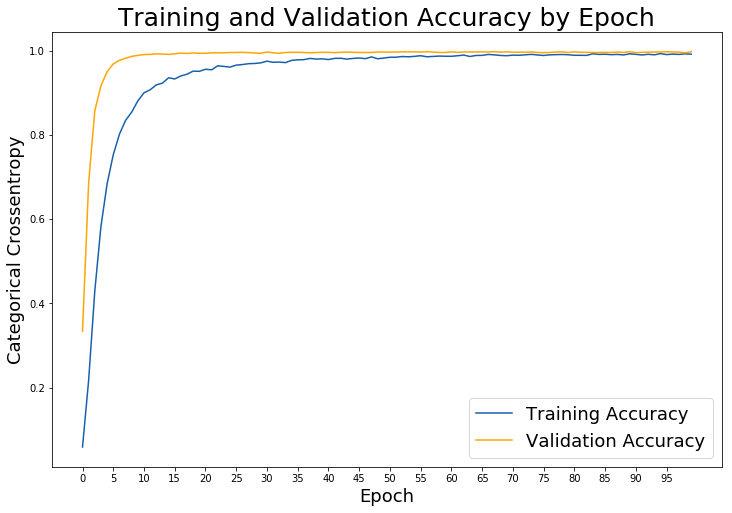

In [570]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);

In [571]:
# We get our predictions from the test data
preds = model.predict_classes(X_test)

In [579]:
# We transform back our predictions to the speakers ids
preds = lb.inverse_transform(preds)

In [580]:
# We slice our dataframe to our test dataframe
df_test = df[11813:]

In [581]:
# We create a new column called preds and set it equal to our predictions
df_test['preds'] = preds

/Users/jurgenarias/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [582]:
# Checking how our test dataframe looks like now with our predictions
df_test

,file,label,speaker,preds
11813,2518-154826-0031.flac,1,2518,2518
11814,254-127705-0028.flac,1,254,254
11815,374-180298-0041.flac,1,374,374
11816,1926-143879-0008.flac,0,1926,1926
11817,1116-132847-0002.flac,0,1116,1116
...,...,...,...,...
13120,1743-142914-0013.flac,1,1743,1743
13121,27-123349-0032.flac,1,27,27
13122,1898-145724-0026.flac,0,1898,1898
13123,2182-181183-0001.flac,0,2182,2182


In [588]:
# Checking how many speakers we got wrong
df_test[df_test['speaker'] != df_test['preds']]

,file,label,speaker,preds
12095,211-122442-0028.flac,0,211,2416
12963,696-93314-0002.flac,0,696,198


In [590]:
# Checking our model accuracy
1-round(len(df_test[df_test['speaker'] != df_test['preds']])/len(df_test),3)

0.998

#### 99.8% accurate on test data for classification of speakers